# Churn Modeling and Analysis

In [86]:
import pandas as pd
import  numpy as np
from sklearn.linear_model import LogisticRegression
#from sklearn import preprocessing, cross_validation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
style.use('ggplot')
%matplotlib inline
import plotly.plotly as py
from sklearn.ensemble import RandomForestClassifier
import plotly.tools as tls
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from IPython.display import display, HTML
from sklearn.metrics import roc_curve, auc,roc_auc_score

### Loading dataset

In [87]:
directory = "D:\churn-modeling"
churn_train_df = pd.read_csv(directory + "\dataset\churn.csv")
print(churn_train_df.shape)

(5000, 21)


### Understanding the data in dataset: Data Exploration 

Data exploration is the first step in data analysis and typically involves summarizing the main characteristics of a dataset. It is commonly conducted using visual analytics tools, but can also be done in more advanced statistical software.

We can do data exploration in Python, R which are advance statistical software.
In general and easy way is to use visual analytics tool/ reporting tools like PowerBI, Tableau, Zoho, Excel, etc.   

Step 1) Understand all the colums in dataset
  
This helps in identify the required features which should be used for modeling

Lets look at the headers in the data set




In [88]:
# state, -> They are state code (2 character)
# account length,
# area code,
# phone number, -> can be used as customer identifier (not part of feature)
# international plan, => yes no
# voice mail  plan,  => yes no
# number vmail messages,   -> vmail is voice-mail
# total day minutes,
# total day calls,
# total day charge,
# total eve minutes,
# total eve calls,
# total eve charge,
# total night minutes,
# total night calls,
# total night charge,
# total intl minutes,
# total intl calls,
# total intl charge,   intl -> international
# customer service calls, -> call made to customer service center
# churn -> Label which we need to predict in future


Step 2) Feature Analysis 
  
This helps in identify the required features, completeness of data, clearity of data, making statergy to improve data quality etc.  



In [89]:
# check the training set for any null value if any
print(churn_train_df.isnull().sum())

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     4
dtype: int64


In [90]:
# Now for this data set we don't have much null value so we don't have much issues with data completeness quality
# if in case we have some/many NULLs the we need to fill the NULLs with some value that depends on the type of data
# which we need to identify by going through data and understanding required pattern and fill missing data.
# There are many approach 
# 1) Manually adding required details from actual data gather from research 
# 2) We may replace by some aggregation 
# 3) We may fill with outlander  value such as -99999 if int or some default value
# Mostly try to fill the values if possible rather then removing those columns/ rows

# In our case only one value is missing from churn column which we can easily assume that that client has churned 

churn_train_df.churn.fillna('TRUE', inplace = True)


In [91]:
# Again check the training set for any null value if any
print(churn_train_df.isnull().sum())

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64


### Preparing the data for research and modeling 

In [92]:
# First we need to convert our String labels to Numerical value ie  YES as 1 and NO as 0 likewise TRUE as 1, FALSE as 0
try:
    churn_train_df['voice mail plan'] = churn_train_df['voice mail plan'].replace(["yes", "no"], [1, 0])
    churn_train_df['international plan'] = churn_train_df['international plan'].replace(["yes", "no"], [1, 0])
    churn_train_df['churn'] = churn_train_df['churn'].replace(["TRUE", "FALSE"," TRUE", " FALSE"," TRUE ", " FALSE "],
                                                              [1,0,1,0,1,0])

    # converting boolean column to 1 AND 0
    churn_train_df.churn = churn_train_df.churn * 1
except TypeError:
    print("Already converted")

In [93]:
# Now need to convert state  to numeric as this my also play important role in data modeling
state_list = list(churn_train_df['state'].unique())
churn_train_df.state = churn_train_df.state.apply(state_list.index)

### We need to check how balance is this data set 

In [94]:
col = churn_train_df.columns.tolist()
print("people churn: {} %".format(round(float(len(churn_train_df[churn_train_df['churn'] == 1])) / len(churn_train_df) * 100), 3))

people churn: 14 %


#### The data set is unbalanced 

In [95]:
# Possible columns which we can consider as feature are state,international plan,voice mail plan,day calls,day charges
# eve calls,eve charges, night calls, night charges, intl calls,intl charges,customer service calls,num vmail messages

heads = ["state", "international plan", "voice mail plan", "number vmail messages", "total day calls",
                            "total day charge", "total eve calls", "total eve charge", "total night calls",
                            "total night charge", "total intl calls", "total intl charge","customer service calls",
                            "churn"]

train_set = churn_train_df[heads]


In [96]:
print(churn_train_df.head(3))

   state  account length  area code phone number  international plan  \
0      0             128        415     382-4657                   0   
1      1             107        415     371-7191                   0   
2      2             137        415     358-1921                   0   

   voice mail plan  number vmail messages  total day minutes  total day calls  \
0                1                     25              265.1              110   
1                1                     26              161.6              123   
2                0                      0              243.4              114   

   total day charge  ...    total eve calls  total eve charge  \
0             45.07  ...                 99             16.78   
1             27.47  ...                103             16.62   
2             41.38  ...                110             10.30   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.0

In [97]:
# Always Check if the data transformation happened as required  

print(churn_train_df['international plan'].unique())
print(churn_train_df['voice mail plan'].unique())
print(churn_train_df['churn'].unique())
print(churn_train_df['state'].unique())


[0 1]
[1 0]
[0 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50]


## Understanding Data


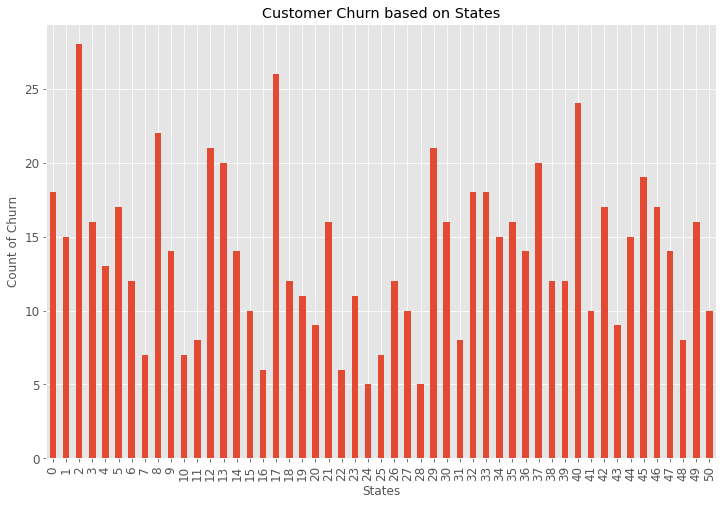

In [98]:
state_churn = train_set.groupby(['state', 'churn'], sort=True).size().reset_index(name='Count')

state_churn_0 = state_churn[state_churn['churn'] == 0].reset_index()
del state_churn_0['index']

state_churn_1 = state_churn[state_churn['churn'] == 1].reset_index()
del state_churn_1['index']

ax = state_churn_1['Count'].plot(kind='bar', title ="Customer Churn based on States", figsize=(12, 8), fontsize=12)
ax.set_xlabel("States", fontsize=12)
ax.set_ylabel("Count of Churn", fontsize=12)
plt.show()

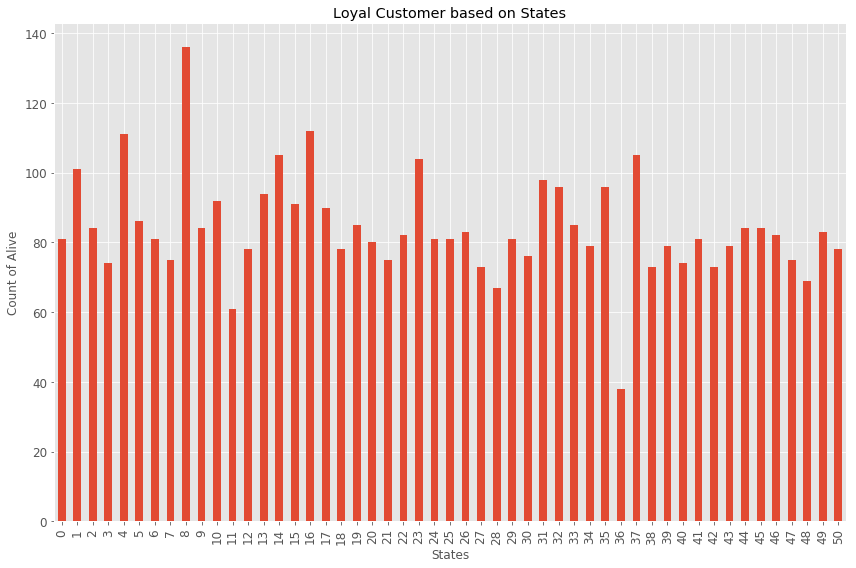

In [99]:

ax = state_churn_0['Count'].plot(kind='bar', title ="Loyal Customer based on States", figsize=(12, 8), fontsize=12)
ax.set_xlabel("States", fontsize=12)
ax.set_ylabel("Count of Alive", fontsize=12)
plt.tight_layout()

### Best way is to use some Visualization tools to quickly understand relations But we can also use matplotlib - python library to identify patterns.  

# Modeling using different available Models

### As it dataset is unbalanced so we can't completely depend on accuracy, as in worst case the accuracy of data set will give 86% accuracy due to  Accuracy paradox

Model Evaluation Basics
The formula for accuracy is: 
 A(M) = (TN+TP)/(TN+TP+FP+FN)

TP is the number of true positives : Predicted as churned and they do

TN is the number of true negatives: Predicted as remaining and they do

FP is the number of false positives: Predicted as they will churn, but they don’t

FN is the number of false negatives: Predicted as won’t churner but they churn

When working with unbalanced dataset we can’t completely depend on Accuracy alone, we need to check the result of other matrix along with accuracy and they are:

• Sensitivity/Recall: how well the model recalls/identifies those that will leave. AKA the true positive rate

• Specificity: how well the model identifies those that will stay. 

• Precision: This talks about how believable is the model? A low precision model will alarm you to those who are leaving that are actually staying.

• F1 score:It is the harmonic mean between precision and recall or the balance. 

 

### Linear Support Vector Classifier 

Linear SVC
Accuracy:   0.1984


Note 
 0: Alive and 1:Churned
             precision    recall  f1-score   support

          0       0.98      0.08      0.14      2164
          1       0.14      0.99      0.25       336

avg / total       0.86      0.20      0.16      2500

AUC =  0.531940410175


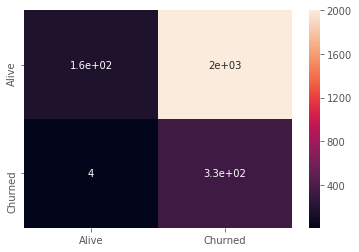

In [100]:
from sklearn.svm import LinearSVC

feature_names  = ["state", "international plan", "voice mail plan", "number vmail messages", "total day calls",
                            "total day charge", "total eve calls", "total eve charge", "total night calls",
                            "total night charge", "total intl calls", "total intl charge","customer service calls"]

clf_init = None
X_train, X_test, y_train, y_test = train_test_split(train_set[feature_names],train_set.churn, test_size=0.50,random_state=123456)
clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
clf.fit(X_train, y_train)
churn_col = ['Alive','Churned']
predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Linear SVC")
print("Accuracy:   " + str(accuracy))
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns= churn_col, index=churn_col)
sns.heatmap(cm, annot=True)
print("Note \n 0: Alive and 1:Churned")
print(metrics.classification_report(y_test, predicted))

# calculating AUC   
lrf_auc = roc_auc_score(y_test ,predicted,average='macro', sample_weight=None)
print("AUC = ", lrf_auc)

# storing matix
svm_accuracy = metrics.accuracy_score(y_test, predicted)  
svm_confus_matrix = metrics.confusion_matrix(y_test, predicted)  
svm_classification_report = metrics.classification_report(y_test, predicted)  
svm_precision = metrics.precision_score(y_test, predicted, pos_label=1)  
svm_recall = metrics.recall_score(y_test, predicted, pos_label=1)  
svm_f1 = metrics.f1_score(y_test, predicted, pos_label=1)


### Gaussian Naive Bayes Classifier 

Gaussian Naive Bayes Classifier 
Accuracy:   0.86
Note 
0: Alive and 1:Churned
             precision    recall  f1-score   support

          0       0.91      0.93      0.92      2164
          1       0.48      0.41      0.44       336

avg / total       0.85      0.86      0.86      2500

AUC =  0.668979953349


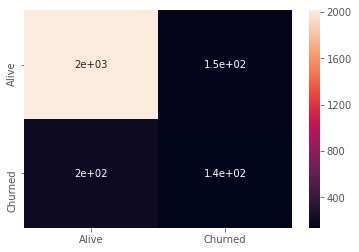

In [101]:
clf_init = None
X_train, X_test, y_train, y_test = train_test_split(train_set[feature_names],train_set.churn, test_size=0.50,random_state=123456)
gnb = GaussianNB()
y_train = y_train.astype('int')
y_test = y_test.astype('int')
gnb.fit(X_train, y_train)
churn_col = ['Alive','Churned']
predicted = gnb.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Gaussian Naive Bayes Classifier ")
print("Accuracy:   " + str(accuracy))
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns= churn_col, index=churn_col)
sns.heatmap(cm, annot=True)
print("Note \n0: Alive and 1:Churned")
print(metrics.classification_report(y_test, predicted))

# calculating AUC   
bayes_auc = roc_auc_score(y_test ,predicted,average='macro', sample_weight=None)
print("AUC = ", bayes_auc)

# storing matrix
bayes_accuracy = metrics.accuracy_score(y_test, predicted)  
bayes_confus_matrix = metrics.confusion_matrix(y_test, predicted)  
bayes_classification_report = metrics.classification_report(y_test, predicted)  
bayes_precision = metrics.precision_score(y_test, predicted, pos_label=1)  
bayes_recall = metrics.recall_score(y_test, predicted, pos_label=1)  
bayes_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

### Gradient Boosting Classifier


Gradient Boosting Classifier
Accuracy:   0.902
Note 
0: Alive and 1:Churned
             precision    recall  f1-score   support

          0       0.94      0.94      0.94      2164
          1       0.64      0.63      0.63       336

avg / total       0.90      0.90      0.90      2500

AUC =  0.788775745973


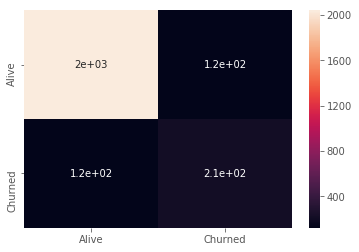

In [102]:
feature_names  = ["state", "international plan", "voice mail plan", "number vmail messages", "total day calls",
                            "total day charge", "total eve calls", "total eve charge", "total night calls",
                            "total night charge", "total intl calls", "total intl charge","customer service calls"]

clf_init = None
X_train, X_test, y_train, y_test = train_test_split(train_set[feature_names],train_set.churn, test_size=0.50,random_state=123456)

clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.2,
                             n_estimators=100, subsample=0.3,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_depth=50,
                             init=clf_init,
                             random_state=None,
                             max_features=None,
                             verbose=0)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

clf.fit(X_train, y_train)

predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Gradient Boosting Classifier")
print("Accuracy:   " + str(accuracy))
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns= churn_col, index=churn_col)
sns.heatmap(cm, annot=True)
print("Note \n0: Alive and 1:Churned")
print(metrics.classification_report(y_test, predicted))

# calculating AUC   
gnb_auc = roc_auc_score(y_test ,predicted,average='macro', sample_weight=None)
print("AUC = ", gnb_auc)

# storing matrix
gbc_accuracy = metrics.accuracy_score(y_test, predicted)  
gbc_confus_matrix = metrics.confusion_matrix(y_test, predicted)  
gbc_classification_report = metrics.classification_report(y_test, predicted)  
gbc_precision = metrics.precision_score(y_test, predicted, pos_label=1)  
gbc_recall = metrics.recall_score(y_test, predicted, pos_label=1)  
gbc_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

### Logistic Regression as Classifier 

Logistic Regression Classifier
Accuracy:   0.8692
Note 
0: Alive and 1:Churned
             precision    recall  f1-score   support

          0       0.88      0.98      0.93      2164
          1       0.54      0.18      0.27       336

avg / total       0.84      0.87      0.84      2500



AUC =  0.576244938826


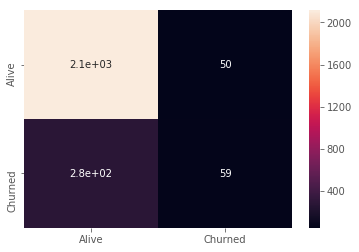

In [103]:
clf_init = LogisticRegression(penalty='l1', dual=False, tol=0.001, C=1.4, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=200, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
clf_init.fit(X_train, y_train)
predicted = clf_init.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Logistic Regression Classifier")
print("Accuracy:   " + str(accuracy))
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns= churn_col, index=churn_col)
sns.heatmap(cm, annot=True)
print("Note \n0: Alive and 1:Churned")
print(metrics.classification_report(y_test, predicted))

# calculating AUC   
lr_auc = roc_auc_score(y_test ,predicted,average='macro', sample_weight=None)
print("AUC = ", lr_auc)

# Store metrics
lrf_accuracy = metrics.accuracy_score(y_test, predicted)  
lrf_confus_matrix = metrics.confusion_matrix(y_test, predicted)  
lrf_classification_report = metrics.classification_report(y_test, predicted)  
lrf_precision = metrics.precision_score(y_test, predicted, pos_label=1)  
lrf_recall = metrics.recall_score(y_test, predicted, pos_label=1)  
lrf_f1 = metrics.f1_score(y_test, predicted, pos_label=1)


### Random Forest Classifier 

Random Forest Classifier
Score Estimate:  0.952
Accuracy:   0.943272727273
Note
 0: Alive and 1:Churned
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      2368
          1       0.94      0.63      0.76       382

avg / total       0.94      0.94      0.94      2750

AUC =  0.812277796448


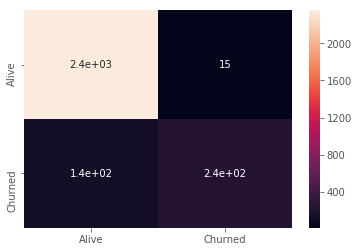

In [104]:
feature_names  = ["state", "international plan", "voice mail plan", "number vmail messages", "total day calls",
                            "total day charge", "total eve calls", "total eve charge", "total night calls",
                            "total night charge", "total intl calls", "total intl charge","customer service calls"]

X_train, X_test, y_train, y_test = train_test_split(train_set[feature_names],train_set.churn, test_size=0.55,random_state=123456)
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
rf.fit(X_train, y_train)
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print("Random Forest Classifier")
print("Score Estimate:  " + str(rf.oob_score_))
print("Accuracy:   " + str(accuracy))
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns= churn_col, index=churn_col)
sns.heatmap(cm, annot=True)
print("Note\n 0: Alive and 1:Churned")
print(metrics.classification_report(y_test, predicted))

# calculating AUC   
rf_auc = roc_auc_score(y_test ,predicted,average='macro', sample_weight=None)
print("AUC = ", rf_auc)


# Store metrics
rf_accuracy = metrics.accuracy_score(y_test, predicted)  
rf_confus_matrix = metrics.confusion_matrix(y_test, predicted)  
rf_classification_report = metrics.classification_report(y_test, predicted)  
rf_precision = metrics.precision_score(y_test, predicted, pos_label=1)  
rf_recall = metrics.recall_score(y_test, predicted, pos_label=1)  
rf_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [105]:
# Model comparison
model = dict({  
  'Model': np.array(['Logistic', 'GB      ', 'r.f.    ', 'SVC     ',  'Bayes   ']),
  'Accuracy' : np.array([float("{:.2f}".format( lrf_accuracy)), float("{:.2f}".format(gbc_accuracy)), float("{:.2f}".format(rf_accuracy)), float("{:.2f}".format(svm_accuracy)), float("{:.2f}".format(bayes_accuracy))]),
  'Precision': np.array([float("{:.2f}".format(lrf_precision)), float("{:.2f}".format(gbc_precision)),float("{:.2f}".format( rf_precision)), float("{:.2f}".format( svm_precision)),float("{:.2f}".format(  bayes_precision))]),
  'recall' : np.array([float("{:.2f}".format(lrf_recall)),float("{:.2f}".format( gbc_recall)), float("{:.2f}".format( rf_recall)),float("{:.2f}".format( svm_recall)),float("{:.2f}".format(bayes_recall))]),
  'F1' : np.array([float("{:.2f}".format(lrf_f1)),float("{:.2f}".format(gbc_f1)),float("{:.2f}".format(rf_f1)),float("{:.2f}".format(svm_f1)),float("{:.2f}".format(bayes_f1))]),
  'AUC' : np.array([float("{:.2f}".format(lr_auc)),float("{:.2f}".format(gnb_auc)),float("{:.2f}".format(rf_auc)),float("{:.2f}".format(lrf_auc)),float("{:.2f}".format(bayes_auc))])
})

models = pd.DataFrame.from_dict(model, orient='index')
models = models.transpose()
from IPython.display import display, HTML

# Print table and sort by test precision
display(models[['Model','AUC','Precision','Accuracy','recall','F1']].sort_values(by='AUC', ascending=False))


We found that Gradient Boosting Classifier works the best amoung all, as we have hight AUC but we can also go with Random Forest as it is also quite close to Gradient boosting.  

### Predicting the churn on unseen data

In [106]:
directory = "D:\churn-modeling"
churn_p_df = pd.read_csv(directory + "\dataset\check.csv")
final_df = pd.read_csv(directory + "\dataset\check.csv")
print(churn_p_df.isnull().sum())


state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
dtype: int64


In [107]:
# First we need to convert our String labels to Numerical value ie  YES as 1 and NO as 0 
try:
    churn_p_df['voice mail plan'] = churn_p_df['voice mail plan'].replace([" yes", " no"], [1, 0])
    churn_p_df['international plan'] = churn_p_df['international plan'].replace([" yes", " no"], [1, 0])
    state_list = list(churn_p_df['state'].unique())
    churn_p_df.state = churn_p_df.state.apply(state_list.index)
    
except TypeError:
    print("Already converted")

In [108]:
heads = ["state", "international plan", "voice mail plan", "number vmail messages", "total day calls",
                            "total day charge", "total eve calls", "total eve charge", "total night calls",
                            "total night charge", "total intl calls", "total intl charge","customer service calls"]

p_set = churn_p_df[heads]


In [109]:
print(p_set.head(2))

   state  international plan  voice mail plan  number vmail messages  \
0      0                   0                0                      0   
1      1                   0                0                      0   

   total day calls  total day charge  total eve calls  total eve charge  \
0               70             35.90              122             21.48   
1               69             34.68              110             19.13   

   total night calls  total night charge  total intl calls  total intl charge  \
0                104               10.16                 3               3.32   
1                 85               10.81                 5               2.59   

   customer service calls  
0                       0  
1                       1  


### Predicting the churn 

In [110]:
# Rerun the required model: Random forest Classifier   
feature_names  = ["state", "international plan", "voice mail plan", "number vmail messages", "total day calls",
                            "total day charge", "total eve calls", "total eve charge", "total night calls",
                            "total night charge", "total intl calls", "total intl charge","customer service calls"]

clf_init = None
X_train, X_test, y_train, y_test = train_test_split(train_set[feature_names],train_set.churn, test_size=0.50,random_state=123456)

clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.2,
                             n_estimators=100, subsample=0.3,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_depth=50,
                             init=clf_init,
                             random_state=None,
                             max_features=None,
                             verbose=0)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print(final_df.shape)
clf.fit(X_train, y_train)
predicted = clf.predict(p_set)
final_df['churn'] = pd.Series(predicted, index=final_df.index)
print(final_df.head())


(335, 20)


  state  account length  area code phone number international plan  \
0    CO              71        415     332-9896                 no   
1    KY              76        415     407-8575                 no   
2    NJ              87        510     387-2799                 no   
3    IL             117        408     373-9108                 no   
4    WA             177        415     345-3947                 no   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0              no                      0              211.2               70   
1              no                      0              204.0               69   
2              no                      0              223.2              109   
3              no                      0              119.0               82   
4              no                      0              266.1               91   

   total day charge  ...    total eve calls  total eve charge  \
0             35.90  ...         

### Final Prediction can be saved in file and can be used for further decision making

In [114]:
churn_list = final_df.loc[final_df['churn'] == 1].reset_index()

print(churn_list['phone number'])

0      345-3947
1      385-1464
2      379-5885
3      342-1004
4      405-5513
5      348-5728
6      345-4589
7      349-3005
8      417-4456
9      421-1326
10     359-3423
11     385-7157
12     385-4766
13     341-4873
14     394-5489
15     393-8762
16     366-8939
17     416-3649
18     337-1586
19     415-5476
20     332-2650
21     345-6961
22     346-5992
23     345-3787
24     345-1994
25     369-8574
26     370-9622
27     351-2815
28     378-1884
29     384-6132
30     338-6714
31     334-6129
32     377-4975
33     411-6823
34     408-1913
35     367-5226
36     373-7974
37     345-3614
38     404-5840
39     335-7324
40     417-1488
41     330-7137
42     411-5677
43     409-1856
44     362-5899
Name: phone number, dtype: object
